<a href="https://colab.research.google.com/github/SruthyDataSculptor/CodeHub_2024/blob/master/Project_Animal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp '/content/drive/MyDrive/animal_project/animal_img.zip' '/content/'

In [ ]:
!unzip /content/drive/MyDrive/animal_project/animal_img.zip -d /content/drive/MyDrive/animal_project/unzip_animals

Archive:  /content/drive/MyDrive/animal_project/animal_img.zip
replace /content/drive/MyDrive/animal_project/unzip_animals/animal_img/animal_1/bear/039b2ae790.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#Importing libraries
import cv2
import glob
import os
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score , confusion_matrix
from sklearn import preprocessing

#tensorflow libraries
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model, Sequential
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

**Creating a Dataframe using dataset**

In [ ]:
path = "/content/drive/MyDrive/animal_project/unzip_animals/animal_img/animal_1"

data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)


df = pd.DataFrame(data)

In [ ]:
with open("/content/drive/MyDrive/animal_project/unzip_animals/animal_img/animals.txt", 'r') as f:
    animal_info = f.read()
print(animal_info.split())

['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']


In [ ]:
animal_dir = "/content/drive/MyDrive/animal_project/unzip_animals/animal_img/animal_1"
len(os.listdir(animal_dir))

15

**Spliting Dataset into Train & Test**

In [ ]:
train_df, Temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124)
valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

#Removing old index columns
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

#Displaying train dataframe
print(train_df[["imgpath", "labels"]].head())

#Checking the shape of dataframe
print(train_df.shape)

                                             imgpath      labels
0  /content/drive/MyDrive/animal_project/unzip_an...  chimpanzee
1  /content/drive/MyDrive/animal_project/unzip_an...        lion
2  /content/drive/MyDrive/animal_project/unzip_an...     leopard
3  /content/drive/MyDrive/animal_project/unzip_an...       tiger
4  /content/drive/MyDrive/animal_project/unzip_an...         dog
(630, 2)


**Checking Image Data**

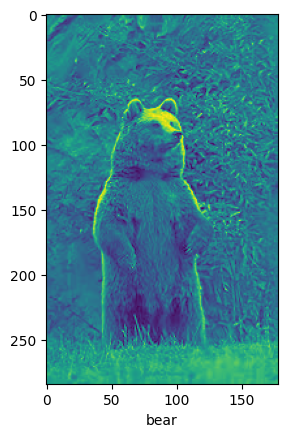

In [ ]:
filepath = "/content/drive/MyDrive/animal_project/unzip_animals/animal_img/animal_1/bear"

for img_path in os.listdir(filepath):
    img = cv2.imread(os.path.join(filepath, img_path), 0)
    plt.imshow(img)
    plt.xlabel(filepath.split("/")[-1])
    plt.show()
    break

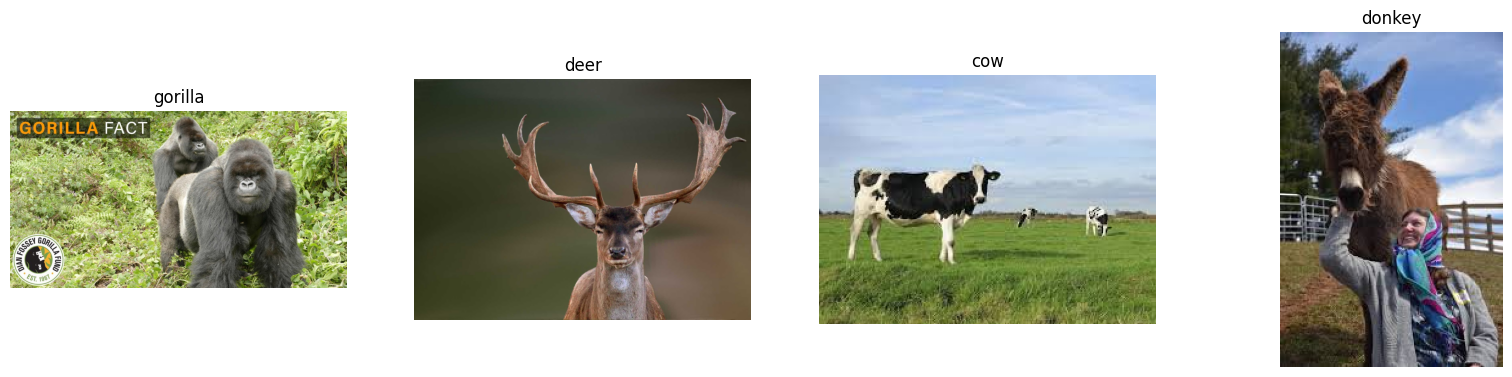

In [ ]:
#Defining size of displayed image
plt.figure(figsize=(20,20))

#Displaying images from test dataframe
for i, row in test_df.sample(n=4).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

**Defining augmentation and dataloaders**

In [ ]:
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)

generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20,
    shear_range=0.2,
    validation_split=0.2
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 630 validated image filenames belonging to 15 classes.
Found 189 validated image filenames belonging to 15 classes.
Found 81 validated image filenames belonging to 15 classes.


**VGG Model**

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)


# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
num_classes = len(set(train_images.classes))


# Data Augmentation Step
sequence = tf.keras.Sequential()


inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = sequence(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                             

In [ ]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
)
model.save_weights('./checkpoints/my_checkpoint')

Epoch 1/10
40/40 [==============================] - 274s 7s/step - loss: 3.2804 - accuracy: 0.0873 - val_loss: 4.7785 - val_accuracy: 0.1270
Epoch 2/10
40/40 [==============================] - 17s 434ms/step - loss: 2.9602 - accuracy: 0.1476 - val_loss: 3.4339 - val_accuracy: 0.1640
Epoch 3/10
40/40 [==============================] - 18s 464ms/step - loss: 2.8765 - accuracy: 0.1540 - val_loss: 2.9146 - val_accuracy: 0.1905
Epoch 4/10
40/40 [==============================] - 18s 442ms/step - loss: 2.5312 - accuracy: 0.2349 - val_loss: 2.4802 - val_accuracy: 0.2540
Epoch 5/10
40/40 [==============================] - 19s 470ms/step - loss: 2.3423 - accuracy: 0.2746 - val_loss: 2.1197 - val_accuracy: 0.3386
Epoch 6/10
40/40 [==============================] - 17s 433ms/step - loss: 2.2360 - accuracy: 0.3079 - val_loss: 2.0667 - val_accuracy: 0.3122
Epoch 7/10
40/40 [==============================] - 18s 461ms/step - loss: 2.0766 - accuracy: 0.3683 - val_loss: 1.9935 - val_accuracy: 0.3968
E

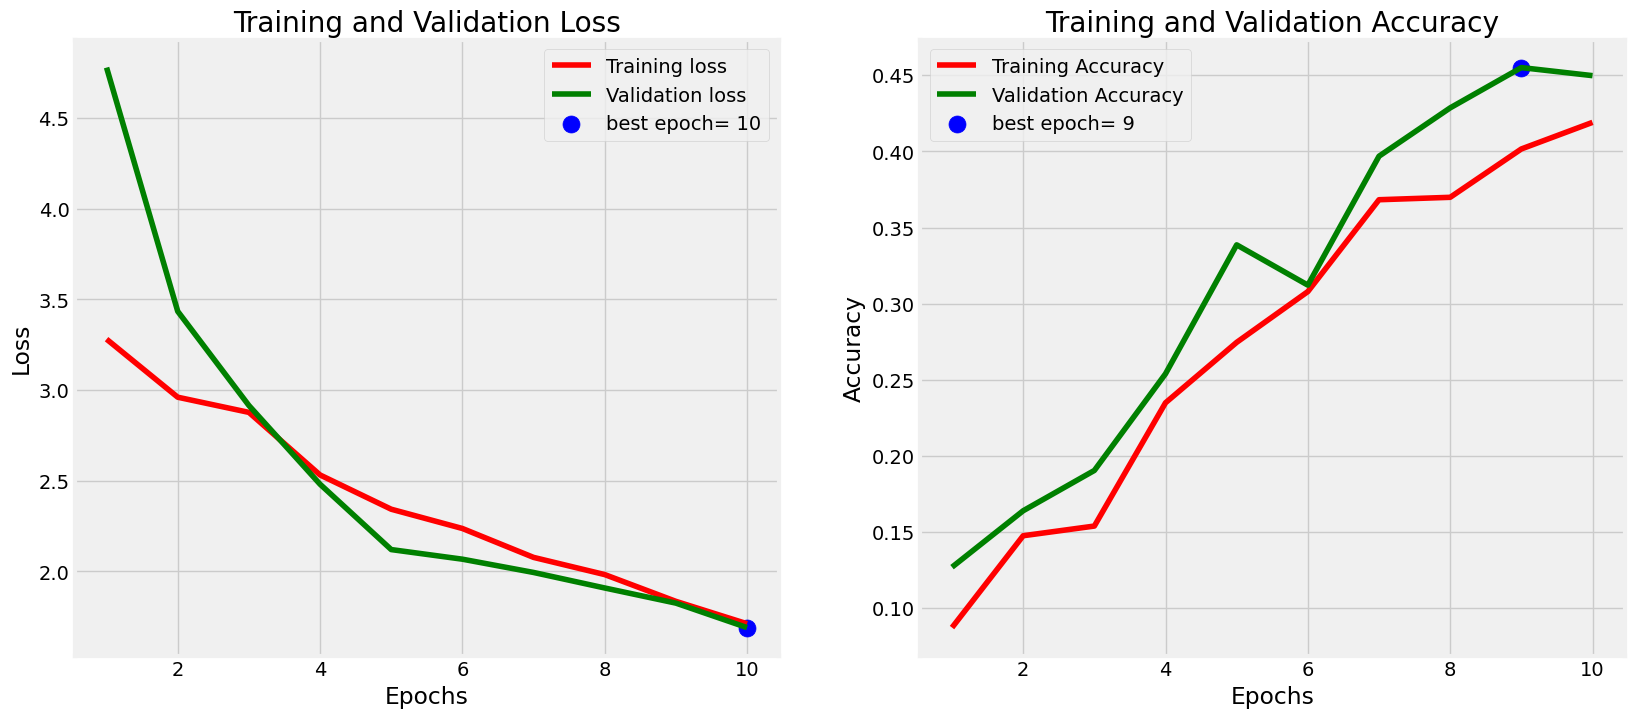

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.68052
Test Accuracy: 43.21%


In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.53162
Test Accuracy: 41.98%


ResNET

In [ ]:
# Load the pretained model
pretrained_resnet = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)


# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_resnet.layers):
    pretrained_resnet.layers[i].trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
num_classes = len(set(train_images.classes))


sequence = tf.keras.Sequential()
inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = sequence(inputs)
pretrain_out = pretrained_resnet(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model_resnet = Model(inputs=inputs, outputs=outputs)


model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model_resnet.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   multiple                  0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                           

In [ ]:
history_resnet = model_resnet.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
)
model_resnet.save_weights('./checkpoints/my_checkpoint2')

Epoch 1/10
40/40 [==============================] - 26s 516ms/step - loss: 3.7200 - accuracy: 0.0905 - val_loss: 3.8451 - val_accuracy: 0.1640
Epoch 2/10
40/40 [==============================] - 17s 439ms/step - loss: 3.0975 - accuracy: 0.1667 - val_loss: 2.6625 - val_accuracy: 0.2751
Epoch 3/10
40/40 [==============================] - 19s 482ms/step - loss: 2.5658 - accuracy: 0.2730 - val_loss: 2.0302 - val_accuracy: 0.3915
Epoch 4/10
40/40 [==============================] - 18s 457ms/step - loss: 2.2136 - accuracy: 0.3095 - val_loss: 1.6707 - val_accuracy: 0.4921
Epoch 5/10
40/40 [==============================] - 19s 473ms/step - loss: 1.9965 - accuracy: 0.3810 - val_loss: 1.5089 - val_accuracy: 0.5238
Epoch 6/10
40/40 [==============================] - 18s 448ms/step - loss: 1.8016 - accuracy: 0.4333 - val_loss: 1.3431 - val_accuracy: 0.5661
Epoch 7/10
40/40 [==============================] - 19s 469ms/step - loss: 1.5534 - accuracy: 0.5048 - val_loss: 1.2288 - val_accuracy: 0.5926

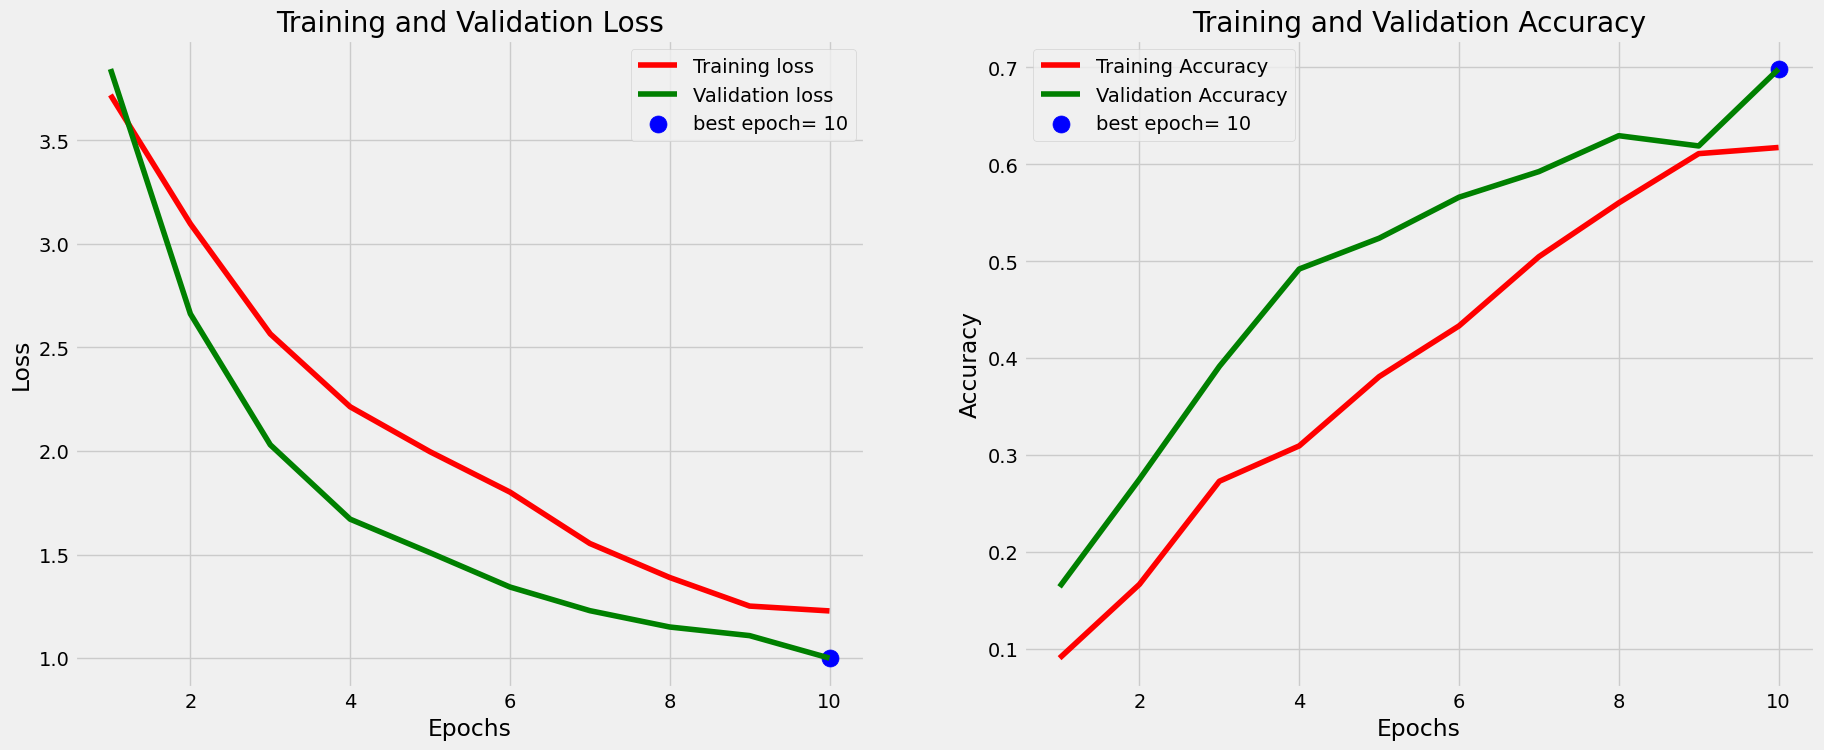

In [ ]:
tr_acc = history_resnet.history['accuracy']
tr_loss = history_resnet.history['loss']
val_acc = history_resnet.history['val_accuracy']
val_loss = history_resnet.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
results = model_resnet.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.90978
Test Accuracy: 67.90%


In [ ]:
pretrained_resnet.trainable = True
for layer in pretrained_resnet.layers:
    if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False

# let`s see first 10 layers
for l in pretrained_resnet.layers[:10]:
    print(l.name, l.trainable)

model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model_resnet.summary())
history = model_resnet.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=15,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), # if val loss decreases for 5 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model_resnet.save_weights('./checkpoints/my_checkpoint3')

input_2 True
conv1_pad True
conv1_conv True
conv1_bn False
conv1_relu True
pool1_pad True
pool1_pool True
conv2_block1_1_conv True
conv2_block1_1_bn False
conv2_block1_1_relu True
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   multiple                  0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 batch_norm

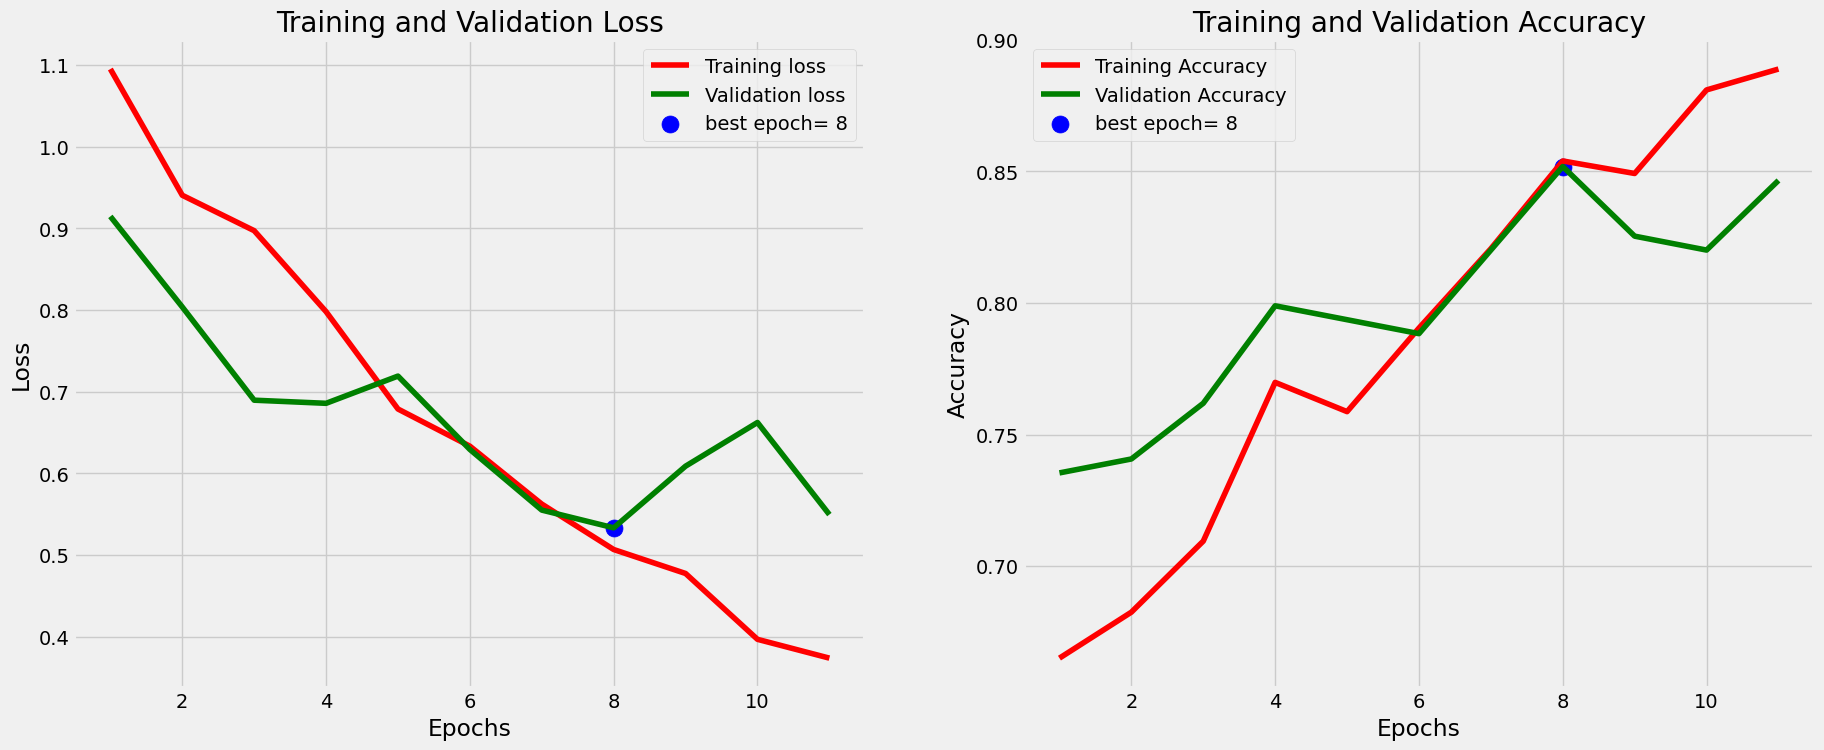

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
results = model_resnet.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.68583
Test Accuracy: 80.25%


In [ ]:
y_true = test_images.classes
y_pred = np.argmax(model_resnet.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

6/6 [==============================] - 4s 292ms/step
F1 Score: 0.7795782774730143
              precision    recall  f1-score   support

        bear       1.00      0.83      0.91         6
  chimpanzee       0.67      0.67      0.67         3
         cow       0.86      1.00      0.92         6
        deer       1.00      0.33      0.50         6
         dog       1.00      1.00      1.00         6
      donkey       0.67      1.00      0.80         4
        goat       0.50      0.33      0.40         3
     gorilla       0.86      0.86      0.86         7
    kangaroo       0.64      0.88      0.74         8
     leopard       1.00      1.00      1.00         7
        lion       0.70      0.88      0.78         8
       snake       1.00      1.00      1.00         2
       tiger       1.00      0.67      0.80         6
        wolf       0.50      0.33      0.40         3
       zebra       0.86      1.00      0.92         6

    accuracy                           0.81        8

In [ ]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))),
                            "Test Labels" : test_images.labels,
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model_resnet.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

6/6 [==============================] - 3s 414ms/step


Image Index  Test Labels Test Classes  Prediction Labels  \
0            0            2          cow                  2   
1            1           10         lion                 10   
2            2            1   chimpanzee                  1   
3            3            9      leopard                  9   
4            4            1   chimpanzee                 10   
5            5            0         bear                  0   
6            6            4          dog                  4   
7            7            6         goat                  2   

  Prediction Classes                                               Path  \
0                cow  /content/drive/MyDrive/animal_project/unzip_an...   
1               lion  /content/drive/MyDrive/animal_project/unzip_an...   
2         chimpanzee  /content/drive/MyDrive/animal_project/unzip_an...   
3            leopard  /content/drive/MyDrive/animal_project/unzip_an...   
4               lion  /content/drive/MyDrive/animal_project/unzip_an...   
5               bear  /content/drive/MyDrive/animal_project/unzip_an...   
6                dog  /content/drive/MyDrive/animal_project/unzip_an...   
7                cow  /content/drive/MyDrive/animal_project/unzip_an...   

   Prediction Probability  
0                0.825059  
1                0.994574  
2                0.790973  
3                0.967865  
4                0.710836  
5                0.990288  
6                0.817770  
7                0.627926

Correct Predictions

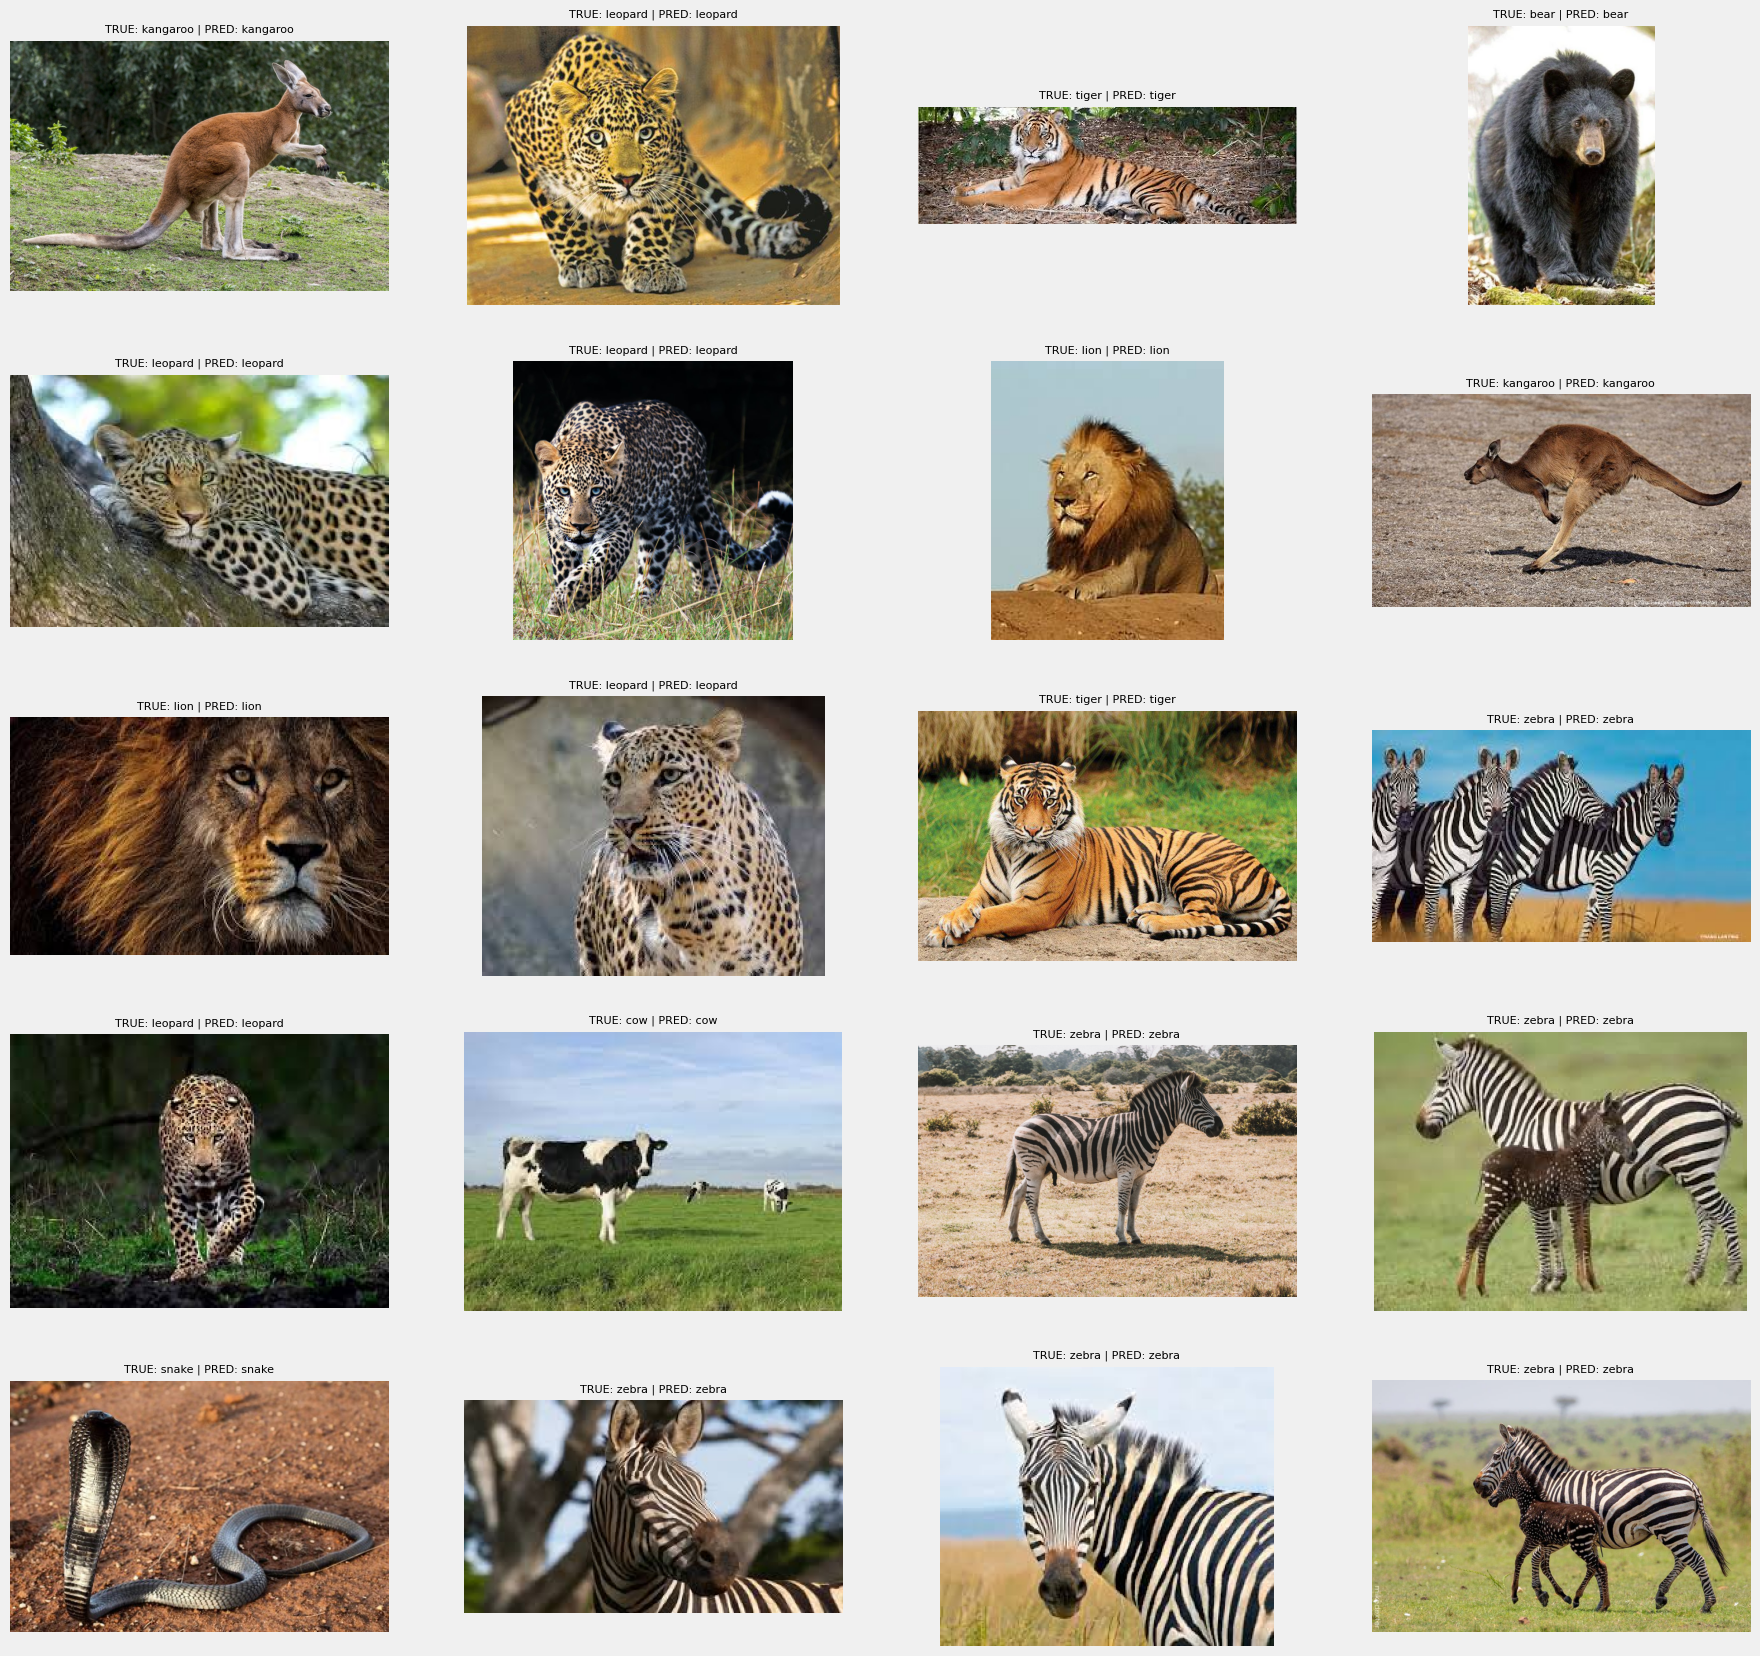

In [ ]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] == Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.show()

Errors

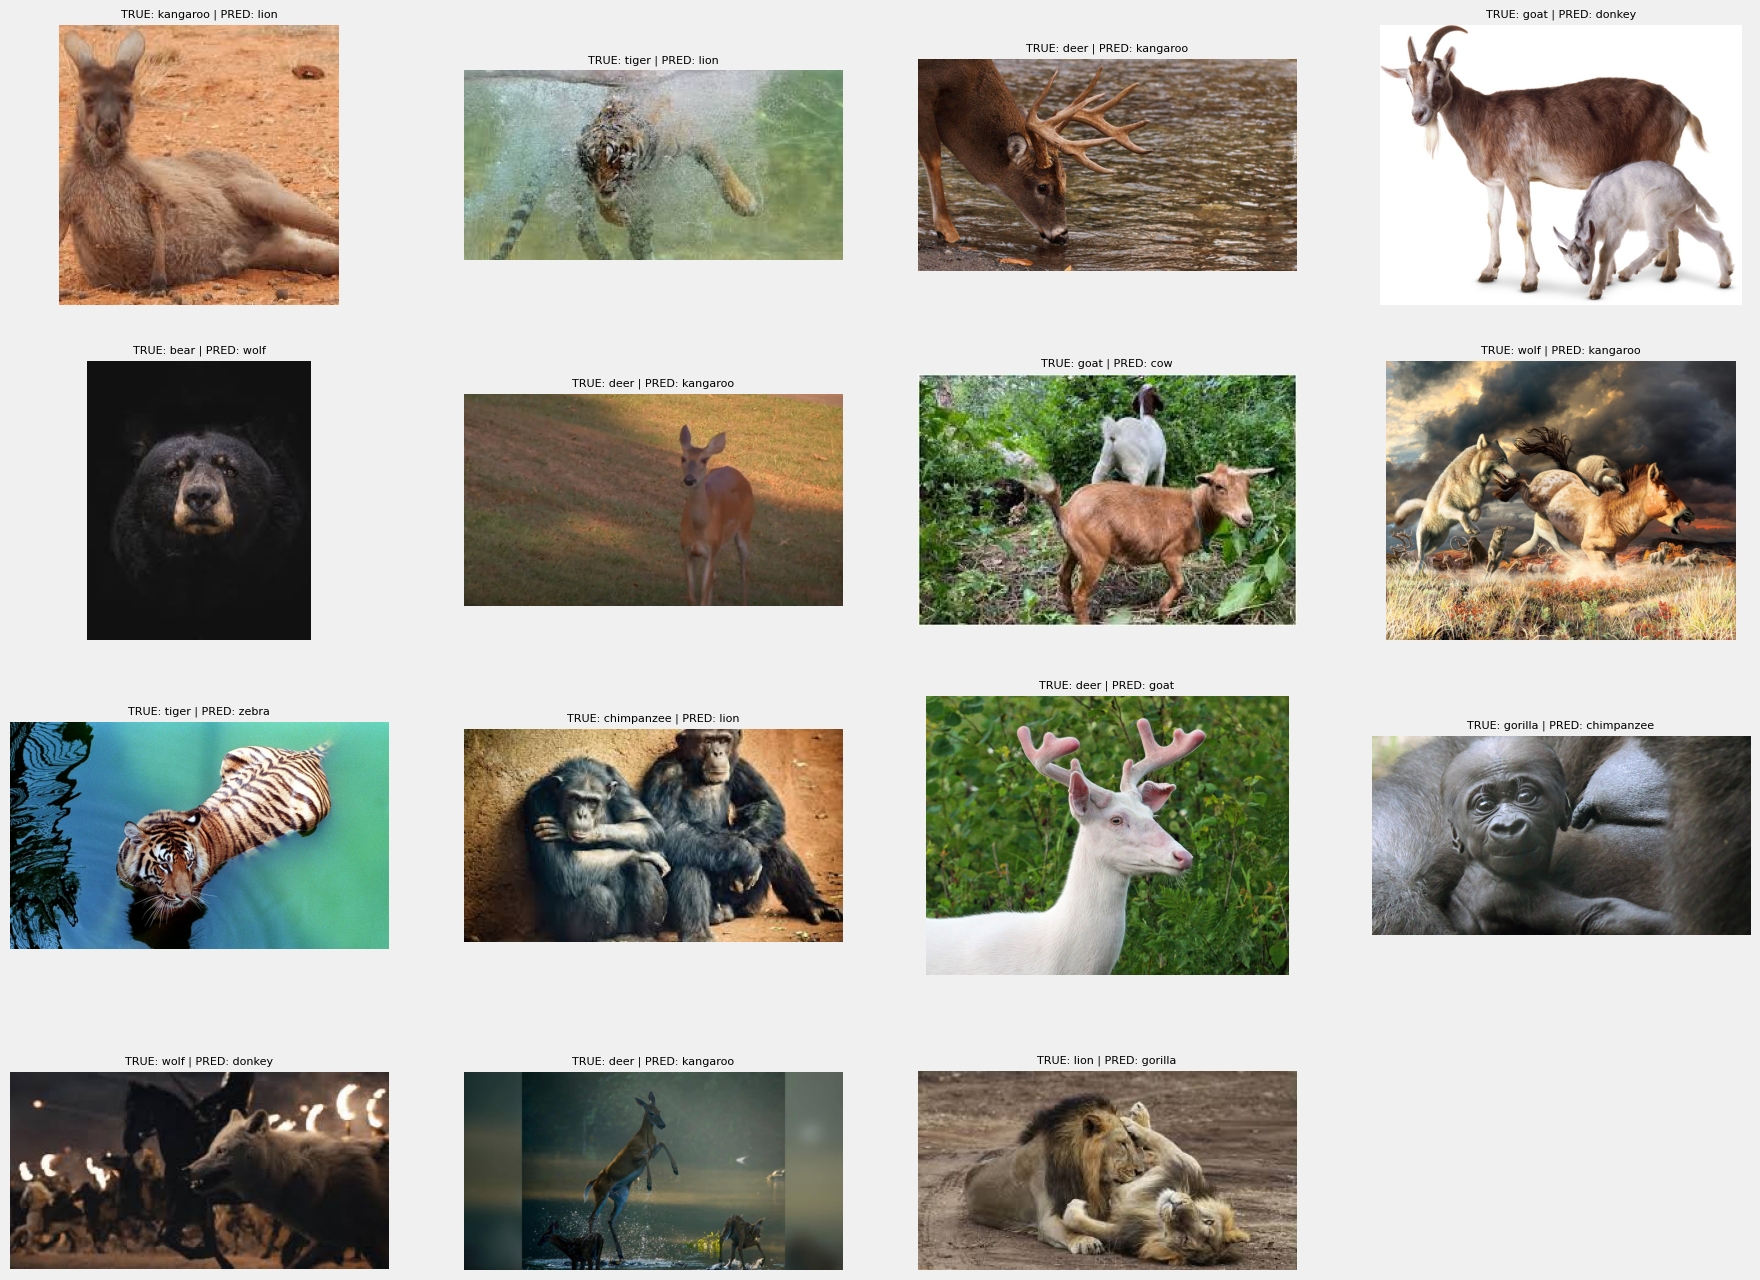

In [ ]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.show()